# Prototype NN model

# Import 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 

In [4]:
df = pd.read_csv('../data/interim_data/clean_ds.csv') # for semplicity i use the clean data (not the normalized one)

In [ ]:
df.head()

,aggregated1,aggregated2,granular1,granular2,granular3,granular4,granular5,id
0,8.00,9.00,8.00,8.00,9.00,8.00,8.00,1
1,6.67,8.33,6.00,7.67,7.00,7.00,6.67,2
2,5.33,4.33,6.33,4.00,6.33,4.33,6.67,3
3,7.67,8.33,7.67,8.33,6.67,7.67,8.67,4
4,7.00,8.33,7.67,8.00,9.00,7.67,8.33,5


# Model

In [6]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Define target and features

In [7]:
target_cols = ['aggregated1', 'aggregated2']
feature_cols = ['granular1', 'granular2', 'granular3', 'granular4', 'granular5']

X = df[feature_cols].values
y = df[target_cols].values

Define train and test set

In [8]:
seed = 0
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state=seed)

In [9]:
X_test

array([[5.  , 8.  , 6.  , 7.  , 7.33],
       [5.  , 7.33, 5.  , 7.  , 3.33],
       [5.  , 7.33, 6.33, 7.  , 7.  ],
       [7.67, 8.  , 9.  , 7.67, 8.33],
       [8.33, 8.  , 8.  , 8.  , 8.  ],
       [6.  , 8.  , 6.  , 7.  , 8.33],
       [7.  , 7.  , 6.33, 7.  , 6.67],
       [7.67, 8.  , 7.33, 8.33, 8.33],
       [4.  , 7.  , 6.33, 7.  , 6.33]])

Define the model

In [10]:
class gilizaNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        return self.net(x)

model = gilizaNN()

Train model 

dataloader, loss and optimizer 

In [11]:
batch_size = 8
lr = 0.001

# ---

x_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
x_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

data_loader = DataLoader(TensorDataset(x_train_t, y_train_t), batch_size = batch_size, shuffle = True)
loss_fnc = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Train model

In [12]:
num_epochs = 100

test_loss_hst, train_loss_hst = [], []
for epoch in range(num_epochs+1):
    model.train()
    running_train_loss = 0
    for xb,yb in data_loader:
        preds = model(xb)
        loss = loss_fnc(preds, yb)
        #
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #
        running_train_loss += loss.item() * xb.size(0)
    
    epoch_train_loss = running_train_loss / len(data_loader.dataset)
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_preds = model(x_test_t)
            test_loss = loss_fnc(test_preds, y_test_t)
        test_loss_hst.append(test_loss.item())
        #
        train_loss_hst.append(epoch_train_loss)
        print(f"Epoch: {epoch} | Train_loss: {epoch_train_loss} | Test_loss: {test_loss} ")

Epoch: 0 | Train_loss: 49.45684567619772 | Test_loss: 32.92752456665039 
Epoch: 10 | Train_loss: 0.6545022620874292 | Test_loss: 1.697497844696045 
Epoch: 20 | Train_loss: 0.5212885772480684 | Test_loss: 1.088238000869751 
Epoch: 30 | Train_loss: 0.47175715250127453 | Test_loss: 1.1099539995193481 
Epoch: 40 | Train_loss: 0.4374147302964154 | Test_loss: 1.171430230140686 
Epoch: 50 | Train_loss: 0.413640814668992 | Test_loss: 1.281754970550537 
Epoch: 60 | Train_loss: 0.3893134734209846 | Test_loss: 1.2629731893539429 
Epoch: 70 | Train_loss: 0.3815742906402139 | Test_loss: 1.1420098543167114 
Epoch: 80 | Train_loss: 0.3635747958632076 | Test_loss: 1.2496006488800049 
Epoch: 90 | Train_loss: 0.34552058928153095 | Test_loss: 1.2588552236557007 
Epoch: 100 | Train_loss: 0.3319973888642648 | Test_loss: 1.3025728464126587 


Eval

Metric eval

In [18]:
type(preds)

torch.Tensor

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error 

model.eval()
with torch.no_grad():
    preds = model(x_test_t)

r2 = r2_score(y_true = y_test_t, y_pred = preds )
mae = mean_absolute_error(y_true = y_test_t, y_pred = preds )
mape = mean_absolute_percentage_error(y_true = y_test_t, y_pred = preds )

r2_agg1 = r2_score(y_true = y_test_t[:,0], y_pred = preds[:,0])
mae_agg1 = mean_absolute_error(y_true = y_test_t[:,0], y_pred = preds[:,0])
mape_agg1 = mean_absolute_percentage_error(y_true = y_test_t[:,0], y_pred = preds[:,0] )

r2_agg2 = r2_score(y_true = y_test_t[:,1], y_pred = preds[:,1])
mae_agg2 = mean_absolute_error(y_true = y_test_t[:,1], y_pred = preds[:,1])
mape_agg2 = mean_absolute_percentage_error(y_true = y_test_t[:,1], y_pred = preds[:,1] )

print("---- Overall ----")
print(f"R2  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.4f}")

print("\n---- Agg1 ----")
print(f"R2  : {r2_agg1:.4f}")
print(f"MAE : {mae_agg1:.4f}")
print(f"MAPE: {mape_agg1:.4f}")

print("\n---- Agg2 ----")
print(f"R2  : {r2_agg2:.4f}")
print(f"MAE : {mae_agg2:.4f}")
print(f"MAPE: {mape_agg2:.4f}")


---- Overall ----
R2  : 0.4685
MAE : 0.8691
MAPE: 0.1807

---- Agg1 ----
R2  : 0.5864
MAE : 0.8934
MAPE: 0.1909

---- Agg2 ----
R2  : 0.3505
MAE : 0.8448
MAPE: 0.1704


Plot 

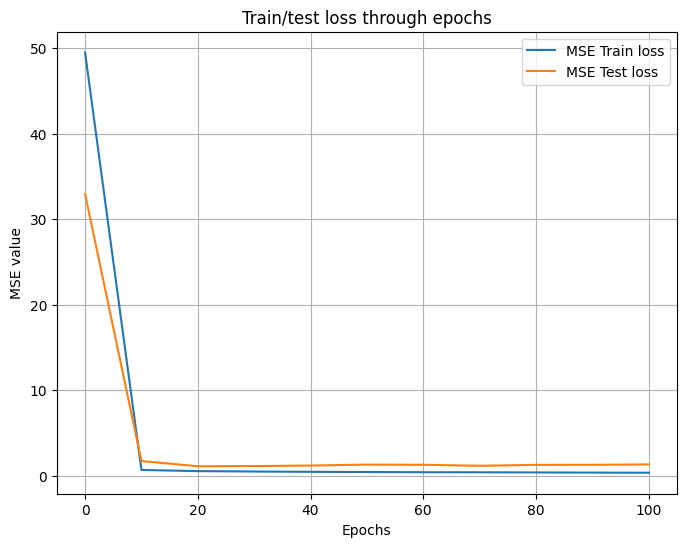


✅ Metriche salvate in: ../report/experiment_plots/20251014_101240_exp_seed0_lr0.001_bs8/metrics.json


In [ ]:
import os, json, datetime

# build new folder 
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
exp_name = f"exp_seed{seed}_lr{lr}_bs{batch_size}"
exp_dir = f"../report/experiment_plots/NN_{timestamp}_{exp_name}"
os.makedirs(exp_dir, exist_ok=True)

# plot

loss_check_point_frq = 10
epochs = [i * loss_check_point_frq for i in range(int(num_epochs/loss_check_point_frq) + 1)]

plt.figure(figsize = (8,6) )
plt.plot(epochs, train_loss_hst, label = "MSE Train loss")
plt.plot(epochs, test_loss_hst, label = "MSE Test loss")
plt.xlabel("Epochs")
plt.ylabel("MSE value")
plt.title("Train/test loss through epochs")
plt.legend()
plt.grid(True)
plt.savefig(f"{exp_dir}/seq_loss.png", dpi=150)
plt.show()

# save config 

config = {
    "model": "gilizaNN",
    "seed": seed,
    "test_size": test_size,
    "epochs": num_epochs,
    "batch_size": batch_size,
    "lr": lr
}

with open(f"{exp_dir}/config.json", "w") as f:
    json.dump(config, f, indent=4)

# --- salva metriche nel folder dell’esperimento ---
metrics = {
    "overall": {"r2": r2, "mae": mae, "mape": mape},
    "agg1": {"r2": r2_agg1, "mae": mae_agg1, "mape": mape_agg1},
    "agg2": {"r2": r2_agg2, "mae": mae_agg2, "mape": mape_agg2},
}

with open(f"{exp_dir}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print(f"\n✅ Metriche salvate in: {exp_dir}/metrics.json")


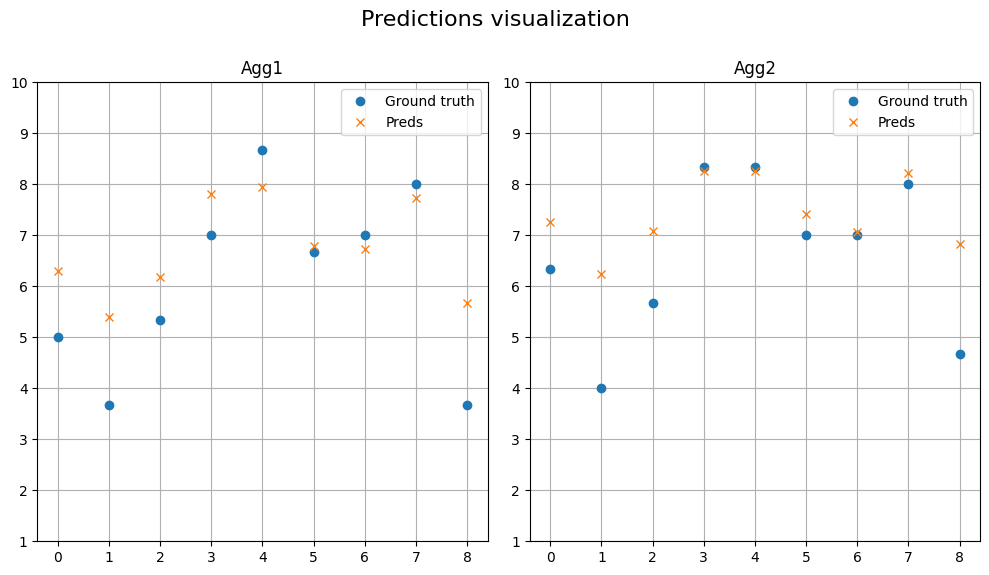

In [15]:
plt.figure(figsize=(10,6))

# Titolo generale
plt.suptitle("Predictions visualization", fontsize=16, y=0.95)

plt.subplot(1,2,1)
plt.title("Agg1")
plt.plot(y_test[:,0], marker='o', linestyle='None', label='Ground truth')
plt.plot(preds[:,0], marker='x', linestyle='None', label='Preds')
plt.ylim(1,10)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.title("Agg2")
plt.plot(y_test[:,1], marker='o', linestyle='None', label='Ground truth')
plt.plot(preds[:,1], marker='x', linestyle='None', label='Preds')
plt.ylim(1,10)
plt.legend()
plt.grid(True)

plt.savefig(f"{exp_dir}/se_preds.png", dpi=150)

# Migliora il layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
